In [2]:
%%time
import json
import inspect
import tqdm
import contractions
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(0,parentdir) 

import Artha
from Artha.nlp_extraction import *


from Artha.binance_api.client import Client
import Artha.configs.binance_config as c 
import time
import numpy as np
import pandas as pd
import datetime

CPU times: user 211 ms, sys: 45.6 ms, total: 257 ms
Wall time: 349 ms


In [22]:
%%time
user = "BTC_JackSparrow"
# user = "CryptoKaleo"
with open("../data/tweets/u"+user+"tweets.json", "r") as r:
    tweets = json.load(r)
tweet_text = []
for ind, tweet in enumerate(tweets):
    sent = tweet["full_text"]
    
    try: #remove tweets of only tagging someone
        while sent[0] == "@":
            sent = sent.split(" ", 1)[1]
        sent = contractions.fix(sent.replace("&amp;", "and").replace("@", ""))
        tweet_text.append((sent, {"created_at":tweet["created_at"], "id" :tweet["id"]}))
    except:
        tweets.pop(ind)

CPU times: user 224 ms, sys: 18.3 ms, total: 242 ms
Wall time: 243 ms


In [23]:
len(tweets)

3166

In [24]:
%%time
docs = []
all_tickers = []
# need to disable pipes
with open("senti.txt", "w+") as w:
    for doc, context in nlp.pipe(tweet_text, as_tuples = True, n_process=-1):
        
        if doc._.tickers:
            all_tickers.extend(doc._.tickers)

            w.write("***"+str(ind)+" "+" ".join(doc._.tickers)+"***"+str(doc._.polarity)+" "+str(doc._.subjectivity)+"\n")
            w.write(doc.text+"\n\n")
        doc._.tweet_id = context["id"]
        doc._.tweeted_at = context["created_at"]
        docs.append(doc)

CPU times: user 2.55 s, sys: 179 ms, total: 2.72 s
Wall time: 4.79 s


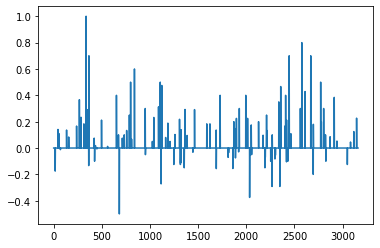

In [25]:
cur_tick = "BTC"
scores = np.zeros(len(docs))
for ind, doc in enumerate(docs):
    if cur_tick in doc._.tickers:
        scores[ind] = doc._.polarity
        # print(doc.text)
        # # print(doc._.tickers)
        # print(doc._.polarity)
plt.plot(np.arange(len(docs)), scores)

In [29]:
docs[-1]._.tweeted_at

'Thu Jan 07 22:56:38 +0000 2021'

In [10]:
docs[0]._.tickers

[]

In [3]:



def process_message(msg):
    print("message type: {}".format(msg['e']))
    print(msg)

key = c.apis[0][0]+"a"
secret = c.apis[0][1]
client = Client(key, secret)

In [4]:
def get_klines(asset, interval, when):
    return client.get_historical_klines(asset, interval, when)

def get_date_str(date):
    obj = datetime.datetime.fromtimestamp(date/1000.0)
    return "%s/%s/%s %s:%s" % (obj.month, obj.day, obj.year, obj.hour, obj.minute)

def get_dataframe(klines):
    columns = ["Open Time", "Open", "High", "Low", "Close", "Volume", "Close Time", "Quote Asset Volume", "Number of Trades", "Taker Buy Base Volume", "Taker Buy Quote Asset Volume", "Ignore"]
    return pd.DataFrame.from_records(
                klines,
                index = pd.date_range(start = get_date_str(klines[0][0]),
                                      end = get_date_str(klines[-1][0]),
                                      periods = len(klines)),
                columns = columns)
    
klines = get_klines("VETBTC", Client.KLINE_INTERVAL_30MINUTE, "3 day ago UTC")

df = get_dataframe(klines)

<AxesSubplot:>

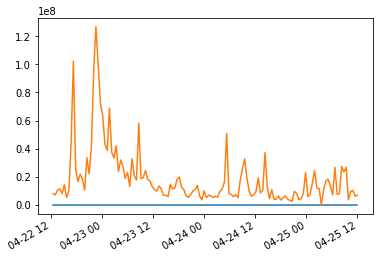

In [5]:
ts = df["Close"].astype(float)
ts2 = df["Volume"].astype(float)
plt.figure()
ts.plot()
ts2.plot()